# Imports/Set up for Q1

In [145]:
!pip install idx2numpy
!pip install python_mnist
from mnist import MNIST
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from google.colab import files
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers as layr
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
mnist_loader = MNIST('/content/drive/My Drive/')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data)
train_label = np.array(train_label)
test_data = np.array(test_data)
test_label = np.array(test_label)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [147]:
#one hot encoding
label_encoded = []
for out in train_label:
  ar = np.zeros(10)
  ar[out] = 1
  label_encoded.append(ar)
label_encoded = np.asarray(label_encoded)
for n in range(0,label_encoded.shape[0]):
  m = train_label[n]
  if label_encoded[n][m] != 1:
    print(False)
print(label_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [148]:
t_d = train_data.astype("float32") / 255
x_train = t_d[:int(train_data.shape[0]*0.8)]
x_test = t_d[int(train_data.shape[0]*0.8):]
stdata = (x_train - np.mean(x_train, axis=0))/x_train.std()
#print(stdata.mean())
#x_train = stdata
y_train = label_encoded[:int(label_encoded.shape[0]*0.8)]
y_test = label_encoded[int(label_encoded.shape[0]*0.8):]
print(x_train.shape)
print(x_test.shape)
layers=3
#print(x_train[1])

(48000, 784)
(12000, 784)


# Question 1

In [149]:
#w for linear regression
weights =[ np.random.normal(0,1,(x_test.shape[1],256)),np.random.normal(0,1,(256, 128)),np.random.normal(0,1,(128, 10)) ]
bias = [ np.random.normal(0,1,(256)),np.random.normal(0,1,(128)),np.random.normal(0,1,(10))  ]
layers=3
epoch = 1
rate = 0.001
ls=[1e10,1e9]

In [ ]:
while np.abs(ls[-1]-ls[-2]) > 1e-4:
  #randomizing batches
  randord = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)
  randx = x_train[randord]
  randy = y_train[randord]
  #batch size of 128 and 375 batches
  #stored as [[x1,y1],[x2,y2]...]
  n=0
  for xbatch,ybatch in [(randx[i:i+128], randy[i:i+128]) for i in range(0,x_train.shape[0],128)]:
    crossent = []
    #print(len(gradw))
    gradw = [[],[],[]]
    gradb = [[],[],[]]
    for x,y in [(xbatch[i],ybatch[i]) for i in range(0, xbatch.shape[0])]:
      #forward pass x->y 1->L-1:
      z= [np.random.rand(x_test.shape[1])]
      z[0] = x
      a= [np.zeros(x_test.shape[0])]
      for l in range(1,layers):
        ##Layer 1->L-1 forward pass
        a.append(weights[l-1].T.dot(z[l-1]) + bias[l-1] )
        relz = a[l]
        relz[relz<0] = 0
        z.append(relz)
      #Layer L forward pass
      #output layer
      a.append((weights[l].T.dot(z[l]))+bias[l])
      #z.append(np.exp(( a[-1] - max(a[-1])))/np.sum( np.exp((a[-1] - max( a[-1] ) )) ))
      z.append(np.exp(( a[-1]- max(a[-1]) ))/np.sum( np.exp((a[-1]- max(a[-1]) )) ))
      yh= z[-1]
      crossent.append(np.log((yh[y>0]+2)))
      if(crossent[-1][0] == 0):
        print(yh,y)
      #crossent.append((yh-y)**2)
      #backward
      ## error L
      e= [np.zeros(256),np.zeros( 128),np.zeros( 10) ]
      e[-1] = yh-y
      ##Error L-1 -> 1, uses W L->2
      for l in reversed(range(layers-1)):
        we = (weights[l+1].dot(e[l+1]) ) 
        hz = np.zeros(z[l+1].shape[0]) # 0 when z<0, else 1
        e[l] = np.multiply(we, hz)
      ##gradients L->1
      for l in reversed(range(layers)):
        gradw[l].append( np.reshape(e[l],(e[l].shape[0],1)) .dot( np.reshape(z[l],(z[l].shape[0],1)).T))
        gradb[l].append(e[l])

    #backward pass{x,y} -> partial Q(W:x)/partial W
    #W^n+1 = W^n - rate/size current batch * sum(for x in B) partial Q(W:x)/partial W
    #Add all backward pass outputs to use
    for l in range(layers):
      weights[l] -= (rate/xbatch.shape[0]) * (np.sum(gradw[l]))
      bias[l] -= (rate/xbatch.shape[0] )* (np.sum(gradb[l]))
  ls.append(np.sum(crossent))
  rate /= 1.1
  print("Epoch " + str(epoch) + " complete. Loss: " + str(ls[-1] ))
  epoch +=1

Epoch 1 complete. Loss: 94.62317169445473
Epoch 2 complete. Loss: 94.39888018901472


In [144]:
cnt=0
tru = 0
print(x_test.shape)
storeout = []
st = []
for x in x_test:
  yf = weights[0].T.dot(x) + bias[0]
  yf[yf<0] == 0
  yf = weights[1].T.dot(yf)  + bias[1]
  yf[yf<0] == 0
  yf = weights[2].T.dot(yf)  + bias[2]
  yf = np.exp(( yf - max(yf))/np.sum( np.exp((yf- max( yf) )) ))
  storeout.append(np.argmax(yf))
  st.append(yf)
  if (np.argmax(y) == np.argmax(yh)):
    tru+=1
  cnt+=1
print(tru)

(12000, 784)
0


[93.58842097074614, 95.21027805702727, 90.752242403049, 94.80481484285835]


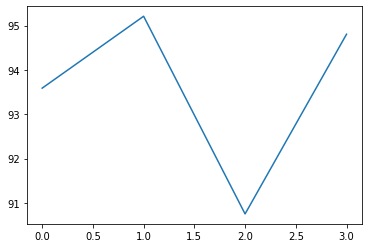

In [142]:
#plt.plot(crossent)
plt.plot((ls[2:]))
print(ls[2:])

# Question 2

In [117]:
num_classes = 10
input_shape = (28, 28, 1)
(xtrain, ytrain), (xtest, ytest) = keras.datasets.mnist.load_data()

xtrain = xtrain.astype("float32") / 255
xtest = xtest.astype("float32") / 255
xtrain = np.expand_dims(xtrain, -1)
xtest = np.expand_dims(xtest, -1)
print("x_train shape:", xtrain.shape)
print(xtrain.shape[0], "train samples")
print(xtest.shape[0], "test samples")
ytrain = keras.utils.to_categorical(ytrain, num_classes)
ytest = keras.utils.to_categorical(ytest, num_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [122]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layr.MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 22, 22, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                77450     
Total params: 133,194
Trainable params: 133,194
Non-trainable params: 0
________________________________________________

In [123]:
batch_size = 128
epochs = 2
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
422/422 [==============================] - 259s 612ms/step - loss: 0.4208 - accuracy: 0.8694 - val_loss: 0.0545 - val_accuracy: 0.9842
Epoch 2/2
422/422 [==============================] - 259s 613ms/step - loss: 0.0524 - accuracy: 0.9836 - val_loss: 0.0470 - val_accuracy: 0.9883
